<h1>Consumer Analysis: Driving Factors of Customer Satisfaction</h1>

What are the biggest driving factors of customer satisfaction? In a survey evaluating peoples experiences purchasing a variety of goods services, participants indicated which factors drove their purchasing choices. Partipants could choose from either previous experience with the provider, a recommendation from a friend, a recommendation from an aquaintence, low prices, company reputation, convenience, and their exposure to advertising. They then rated their degree of satisfaction with their purchasing decision. The following regression analyses reveal that some of these factors are predictors of customer satisfaction, while others are not. 

In [9]:
#Import Dependencies
from functions import regress
from functions import linregress
from functions import summarize
import pandas as pd
#Dependencies
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
import pandas as pd
import sklearn
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

<h2>Aquiring and Cleaning the Data</h2>
<p><b>Dealing with Missing Data.</b></p>  Because these variables are categorical, rather than imputing the mean, using multiple imputation, or imputing the mode, I am opting to drop missing observations.While normally this is ill advised, the former methods would be misleading, since the first two would require us to use values that do not fall into any substantive category, and the last method would skew our data too wildly. There is another good justification for this: we have reason to believe that nonresponse bias will not be a problem for this dataset. Our goal is to discover which of the divers of customer satisfaction are the most influential among those listed, not to determine every underlying cause. If an exogenous factor drove nonresponse, we can still safely say that this model tells us something about preference among those we did test for.

<p><b>Recoding the Variables.</b></p>
In order to make later regression analysis easier to interpret, we recode the dummy variables to have values 0 and 1 (rather than the default 1 and 2). This makes interpretation of the data less ambiguous later.

In [2]:
#Convert data from Stata format to pandas dataframe
gss = pd.io.stata.read_stata('../data/GSS1996.dta',convert_categoricals=False)
itr = pd.read_stata('../data/GSS1996.dta', iterator = True)
gss.to_csv('../data/gss_converted.csv')

In [3]:
#Get list of relevant variable names
full_list=list(gss)
varlist=[]
for item in full_list:
    if item[0:3]=="car" or item[0:3]=="law" or item[0:3] == "fix" or item[0:6]== "realtor":
     varlist.append(item)

#Get list of control variable names
morevars=["degree","region","race","childs","sex","marital", "age"]
for item in morevars:
    varlist.append(item)

In [4]:
#Get varaible labels
labels=itr.variable_labels()
for item in varlist:
    print(f"{item}: {labels[item]}")

fixhome: home maintenance services past 10 years?
lawyer: hired a lawyer in the past 10 yrs? 
carprivt: have you purchased a used car past 5 yrs?
cardealr: purchased a car from a dealership past 5 yrs?
lawyerb: a friend or relative recommended them
lawyera: my own previous knowledge of the firm
lawyerd: general reputation in the community
lawyerc: an acquaintance recommended them.
lawyere: i saw their advertisement
lawyerf: i searched for the best price. 
fixerb: a friend or relative recommended them 
fixera: my own previous knowledge of the firm 
fixerf: i searched for the best price 
fixere: i saw their advertisement 
fixerd: general reputation in the community 
fixerc: an acquaintance recommended them. 
carbuyf: r searched for the best price
carbuya: r's own previous knowledge made r buy
carbuyg: convenience made r buy 
carbuyd: general reputation made r buy
carbuyb: a friend or relative recommended r buy 
carbuyc: an acquaintance recommended r buy
carbuye: r saw their advertisement

In [5]:
#Recode the Variables to make analysis easier

#Dummy Variables: setting these from 1, 2 to 0,
dummylist = ["carprivt", "cardealr", "carbuyf", "carbuya", "carbuyg", "carbuyd", "carbuyb", "carbuyc", "carbuye", "carbuyf", "carbuy1", "realtora", "realtorb", "realtorc", "realtord", "realtore", "realtorf", "fixera", "fixerb", "fixerc", "fixerd", "fixere", "fixerf", "lawyera","lawyerb","lawyerc","lawyerd","lawyere","lawyerf", "lawyerg"]
for item in dummylist:
    gss[f"{item}_r"]=gss[item]
    gss.loc[(gss[item] ==1), f"{item}_r"] = 0
    gss.loc[(gss[item] ==2), f"{item}_r"] = 1

#Control Variables
#Recode sex to dummy, reference category = "female"
gss["sex_r"]=gss["sex"]
gss.loc[gss.sex == 1, 'sex_r'] = 0
gss.loc[gss.sex == 2, 'sex_r'] = 1

#Recode race to dummy, reference category = "nonwhite"
gss["race_r"]=gss["race"]
gss.loc[gss.race == 1, 'race_r'] = 0
gss.loc[gss.race > 1, 'race_r'] = 1

#Recode degree to dummy, reference category = "has no degree" (note that in original study, ref cat was HAS degree)
gss["degree_r"]=gss["degree"]
gss.loc[gss.degree <=3, 'degree_r'] = 0
gss.loc[gss.degree > 3, 'degree_r'] = 1

#Recode region to dummy, reference category = "Not from South"
gss["region_r"]=gss["region"]
gss.loc[(gss.region <=4) | (gss.region >7), 'region_r'] = 0
gss.loc[(gss.region >=5) & (gss.region <=7), 'region_r'] = 1

#Recode marital to new categorical variable with reference category = "single, never married" and divorced and separated categories combined (note that this differs slightly from the original study, which did not assign "0" to any value of the variable.)
#New categories:
#0=single, never married
#1=married
#2=divorced/separated
#3=widowed
gss["marital_r"]=gss["marital"]
gss.loc[(gss.marital ==5), 'marital_r'] = 0
gss.loc[(gss.marital ==4) | (gss.marital ==3), 'marital_r'] = 2
gss.loc[(gss.marital ==3), 'marital_r'] = 3

#Recode parent to dummy, reference category = "is not parent"
gss["childs_r"]=gss["childs"]
gss.loc[(gss.childs >0), 'childs_r'] = 1

#Center the age variable
gss["age_c"]=gss["age"]-gss["age"].mean()

In [6]:
#Drop missing values on data pertaining to each of the types of models we will run (one type per good or service sold), and create a separate dataframe for each.
car=gss.dropna(subset=["carprivt", "satcar", "carbuya", "carbuyb", "carbuyc", "carbuyd", "carbuye", "carbuyf", "carbuyg"]).copy(deep=True)
home=gss.dropna(subset=["sathome","evbuyhme", "realtora", "realtorb", "realtorc", "realtord", "realtore", "realtorf"]).copy(deep=True)
fix=gss.dropna(subset=["satfixes", "fixhome", "fixera", "fixerb", "fixerc", "fixerd", "fixere", "fixerf"]).copy(deep=True)
law=gss.dropna(subset=["satlawyr","lawyer", "lawyera","lawyerb","lawyerc","lawyerd","lawyere","lawyerf", "lawyerg"]).copy(deep=True)

<h1>Preliminary Analysis</h1>
<p><b>Initial Summary Statistics.</b></p>
Before we begin serious analysis, we need to get a broad picture of the data we are working with. Here we produce simple summary statistics for all of the variables in our analysis, as well as bar charts and histograms to give us an idea of the shape of the data. These are rough diagrams, and intentionally not produced in detail. This is just to give  analysts the ability to evaluate at-a-glance what kind of data we will be working with. Most of these variables are dummy variables in response to a survey question asking the participant whether the specific factor they are being asked about was influential in their last service-or-good buying decision.




FIXHOME
Home Maintenance Services Past 10 Years?


count    1444.000000
mean        1.618421
std         0.485942
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: fixhome, dtype: float64


Obs per category
------------------
1.0-> 551 (18.97%)
2.0-> 893 (30.75%)


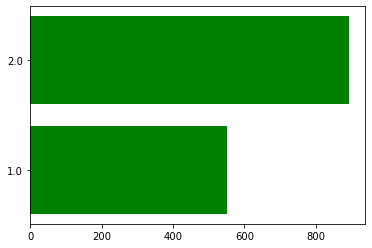




LAWYER
Hired A Lawyer In The Past 10 Yrs? 


count    1444.000000
mean        1.549861
std         0.497680
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: lawyer, dtype: float64


Obs per category
------------------
1.0-> 650 (22.38%)
2.0-> 794 (27.34%)


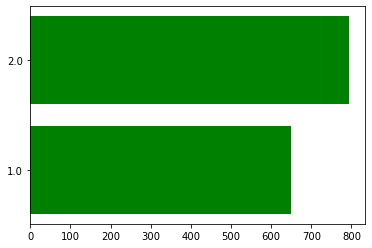




CARPRIVT
Have You Purchased A Used Car Past 5 Yrs?


count    735.000000
mean       1.659864
std        0.474077
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carprivt, dtype: float64


Obs per category
------------------
1.0-> 250 (8.61%)
2.0-> 485 (16.7%)


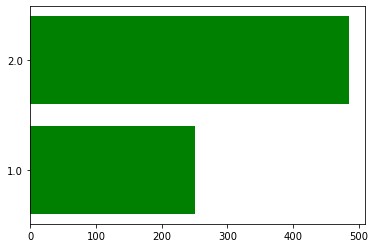




CARDEALR
Purchased A Car From A Dealership Past 5 Yrs?


count    728.000000
mean       1.451923
std        0.498025
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: cardealr, dtype: float64


Obs per category
------------------
1.0-> 399 (13.74%)
2.0-> 329 (11.33%)


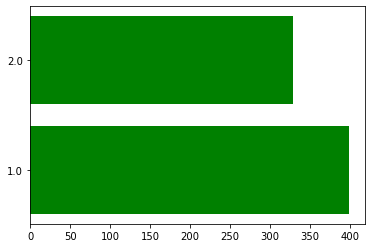




LAWYERB
A Friend Or Relative Recommended Them


count    549.000000
mean       1.491803
std        0.500389
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: lawyerb, dtype: float64


Obs per category
------------------
1.0-> 279 (9.61%)
2.0-> 270 (9.3%)


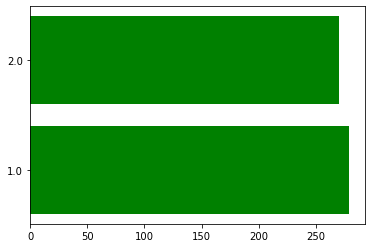




LAWYERA
My Own Previous Knowledge Of The Firm


count    539.000000
mean       1.634508
std        0.482015
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyera, dtype: float64


Obs per category
------------------
1.0-> 197 (6.78%)
2.0-> 342 (11.78%)


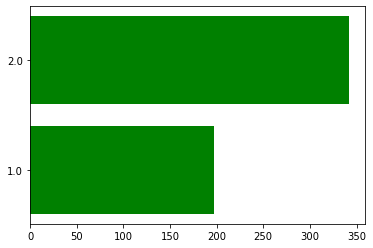




LAWYERD
General Reputation In The Community


count    523.00000
mean       1.74761
std        0.43480
min        1.00000
25%        1.00000
50%        2.00000
75%        2.00000
max        2.00000
Name: lawyerd, dtype: float64


Obs per category
------------------
1.0-> 132 (4.55%)
2.0-> 391 (13.46%)


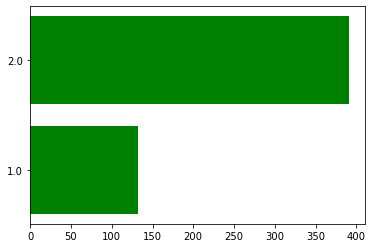




LAWYERC
An Acquaintance Recommended Them.


count    516.000000
mean       1.782946
std        0.412640
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyerc, dtype: float64


Obs per category
------------------
1.0-> 112 (3.86%)
2.0-> 404 (13.91%)


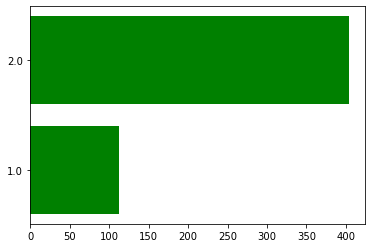




LAWYERE
I Saw Their Advertisement


count    505.000000
mean       1.857426
std        0.349985
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyere, dtype: float64


Obs per category
------------------
1.0-> 72 (2.48%)
2.0-> 433 (14.91%)


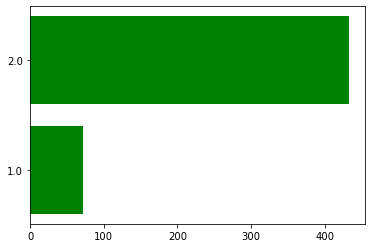




LAWYERF
I Searched For The Best Price. 


count    498.000000
mean       1.909639
std        0.286987
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyerf, dtype: float64


Obs per category
------------------
1.0-> 45 (1.55%)
2.0-> 453 (15.6%)


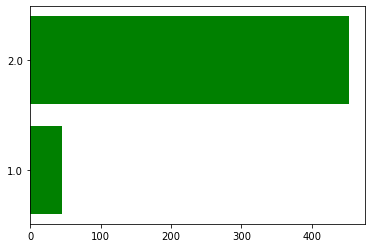




FIXERB
A Friend Or Relative Recommended Them 


count    453.000000
mean       1.551876
std        0.497851
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixerb, dtype: float64


Obs per category
------------------
1.0-> 203 (6.99%)
2.0-> 250 (8.61%)


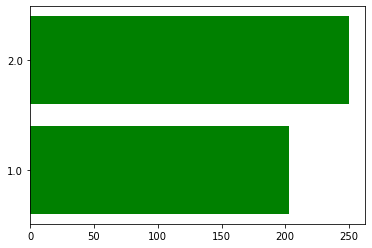




FIXERA
My Own Previous Knowledge Of The Firm 


count    439.000000
mean       1.615034
std        0.487142
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixera, dtype: float64


Obs per category
------------------
1.0-> 169 (5.82%)
2.0-> 270 (9.3%)


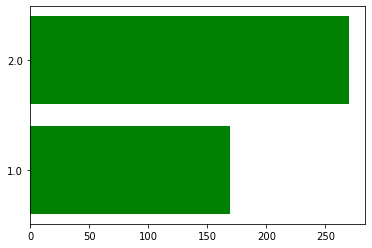




FIXERF
I Searched For The Best Price 


count    423.000000
mean       1.702128
std        0.457865
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixerf, dtype: float64


Obs per category
------------------
1.0-> 126 (4.34%)
2.0-> 297 (10.23%)


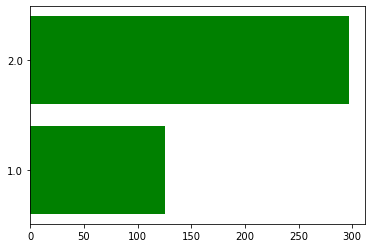




FIXERE
I Saw Their Advertisement 


count    418.000000
mean       1.732057
std        0.443418
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixere, dtype: float64


Obs per category
------------------
1.0-> 112 (3.86%)
2.0-> 306 (10.54%)


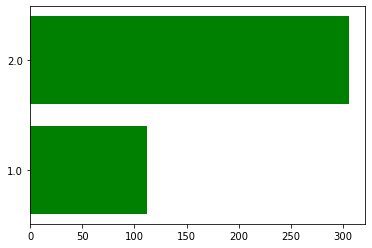




FIXERD
General Reputation In The Community 


count    415.000000
mean       1.703614
std        0.457214
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixerd, dtype: float64


Obs per category
------------------
1.0-> 123 (4.24%)
2.0-> 292 (10.06%)


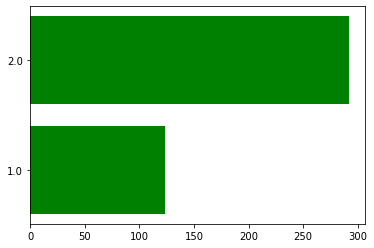




FIXERC
An Acquaintance Recommended Them. 


count    405.000000
mean       1.824691
std        0.380701
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: fixerc, dtype: float64


Obs per category
------------------
1.0-> 71 (2.44%)
2.0-> 334 (11.5%)


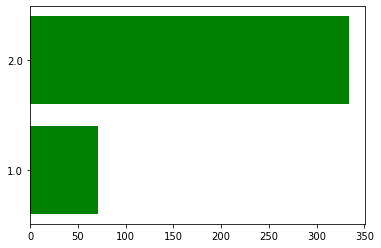




CARBUYF
R Searched For The Best Price


count    334.000000
mean       1.497006
std        0.500741
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: carbuyf, dtype: float64


Obs per category
------------------
1.0-> 168 (5.79%)
2.0-> 166 (5.72%)


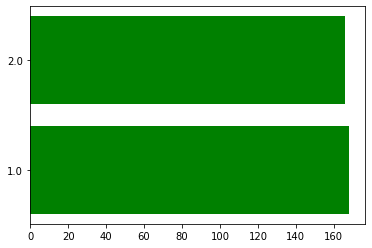




CARBUYA
R'S Own Previous Knowledge Made R Buy


count    330.000000
mean       1.612121
std        0.488007
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuya, dtype: float64


Obs per category
------------------
1.0-> 128 (4.41%)
2.0-> 202 (6.96%)


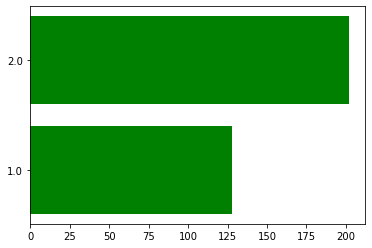




CARBUYG
Convenience Made R Buy 


count    324.000000
mean       1.626543
std        0.484470
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuyg, dtype: float64


Obs per category
------------------
1.0-> 121 (4.17%)
2.0-> 203 (6.99%)


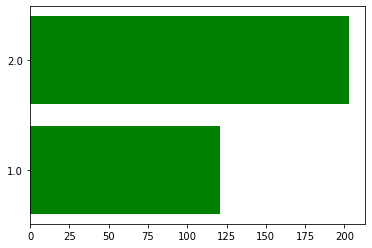




CARBUYD
General Reputation Made R Buy


count    316.000000
mean       1.661392
std        0.473987
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuyd, dtype: float64


Obs per category
------------------
1.0-> 107 (3.68%)
2.0-> 209 (7.2%)


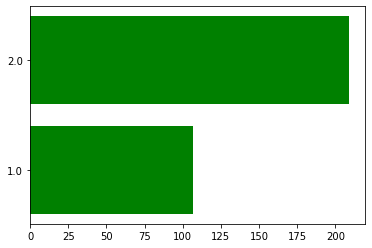




CARBUYB
A Friend Or Relative Recommended R Buy 


count    315.000000
mean       1.647619
std        0.478472
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuyb, dtype: float64


Obs per category
------------------
1.0-> 111 (3.82%)
2.0-> 204 (7.02%)


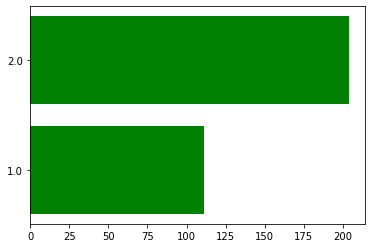




CARBUYC
An Acquaintance Recommended R Buy


count    305.000000
mean       1.875410
std        0.330796
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuyc, dtype: float64


Obs per category
------------------
1.0-> 38 (1.31%)
2.0-> 267 (9.19%)


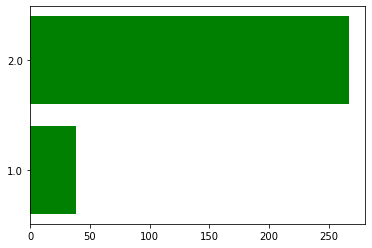




CARBUYE
R Saw Their Advertisement


count    305.000000
mean       1.740984
std        0.438815
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: carbuye, dtype: float64


Obs per category
------------------
1.0-> 79 (2.72%)
2.0-> 226 (7.78%)


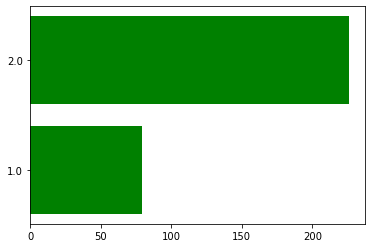




CARBUY1
What Was The Most Important Reason? 


count    186.000000
mean       4.306452
std        2.157992
min        1.000000
25%        2.000000
50%        5.500000
75%        6.000000
max        7.000000
Name: carbuy1, dtype: float64


Obs per category
------------------
1.0-> 35 (1.21%)
2.0-> 23 (0.79%)
3.0-> 5 (0.17%)
4.0-> 20 (0.69%)
5.0-> 10 (0.34%)
6.0-> 76 (2.62%)
7.0-> 17 (0.59%)


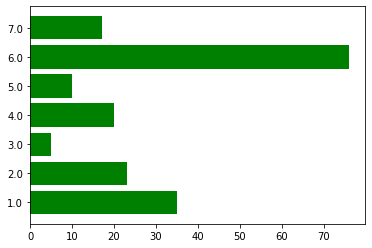




LAWYERG
Convenience


count    173.000000
mean       1.791908
std        0.407122
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: lawyerg, dtype: float64


Obs per category
------------------
1.0-> 36 (1.24%)
2.0-> 137 (4.72%)


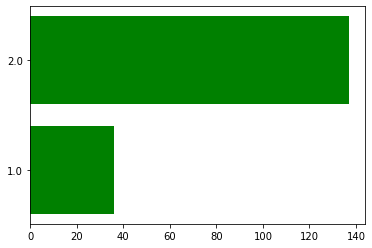




FIXER1
What Was The Most Important Reason? 


count    171.000000
mean       3.508772
std        2.015728
min        1.000000
25%        1.000000
50%        4.000000
75%        6.000000
max        6.000000
Name: fixer1, dtype: float64


Obs per category
------------------
1.0-> 44 (1.52%)
2.0-> 27 (0.93%)
3.0-> 10 (0.34%)
4.0-> 31 (1.07%)
5.0-> 6 (0.21%)
6.0-> 53 (1.83%)


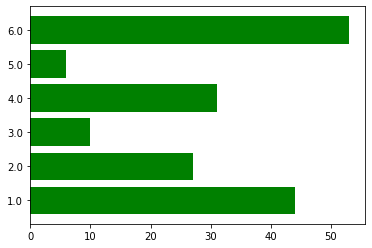




LAWYER1
What Was The Most Important Reason?


count    158.000000
mean       2.696203
std        1.562738
min        1.000000
25%        1.250000
50%        2.000000
75%        4.000000
max        7.000000
Name: lawyer1, dtype: float64


Obs per category
------------------
1.0-> 40 (1.38%)
2.0-> 51 (1.76%)
3.0-> 17 (0.59%)
4.0-> 33 (1.14%)
5.0-> 4 (0.14%)
6.0-> 10 (0.34%)
7.0-> 3 (0.1%)


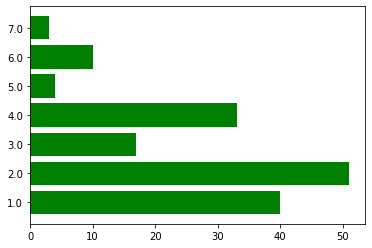




DEGREE
R'S Highest Degree


count    2897.000000
mean        1.467035
std         1.160929
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: degree, dtype: float64


Obs per category
------------------
0.0-> 448 (15.43%)
1.0-> 1567 (53.96%)
2.0-> 187 (6.44%)
3.0-> 471 (16.22%)
4.0-> 224 (7.71%)


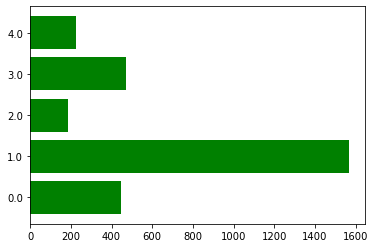




REGION
Region Of Interview


count    2904.000000
mean        4.988636
std         2.502126
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max         9.000000
Name: region, dtype: float64


Obs per category
------------------
1-> 157 (5.41%)
2-> 412 (14.19%)
3-> 489 (16.84%)
4-> 210 (7.23%)
5-> 542 (18.66%)
6-> 209 (7.2%)
7-> 265 (9.13%)
8-> 200 (6.89%)
9-> 420 (14.46%)


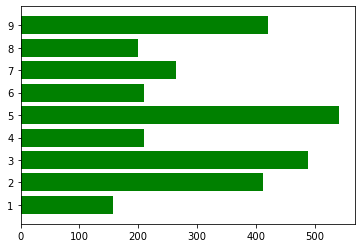




RACE
Race Of Respondent


count    2904.000000
mean        1.243802
std         0.538362
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: race, dtype: float64


Obs per category
------------------
1-> 2349 (80.89%)
2-> 402 (13.84%)
3-> 153 (5.27%)


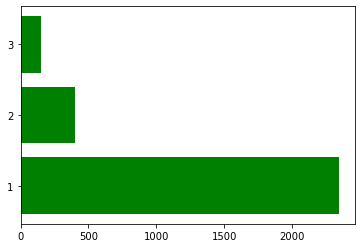




CHILDS
Number Of Children


count    2889.000000
mean        1.833160
std         1.681493
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: childs, dtype: float64


Obs per category
------------------
0.0-> 822 (28.31%)
1.0-> 461 (15.87%)
2.0-> 770 (26.52%)
3.0-> 420 (14.46%)
4.0-> 222 (7.64%)
5.0-> 94 (3.24%)
6.0-> 48 (1.65%)
7.0-> 27 (0.93%)
8.0-> 25 (0.86%)


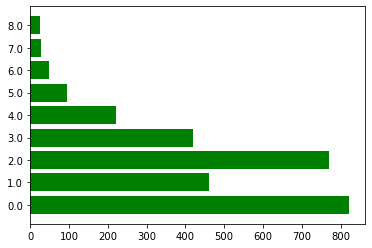




SEX
Respondents Sex


count    2904.000000
mean        1.557507
std         0.496767
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: sex, dtype: float64


Obs per category
------------------
1-> 1285 (44.25%)
2-> 1619 (55.75%)


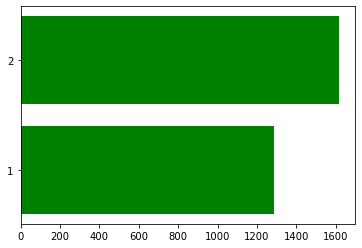




MARITAL
Marital Status


count    2903.000000
mean        2.439201
std         1.626688
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         5.000000
Name: marital, dtype: float64


Obs per category
------------------
1.0-> 1390 (47.87%)
2.0-> 282 (9.71%)
3.0-> 455 (15.67%)
4.0-> 118 (4.06%)
5.0-> 658 (22.66%)


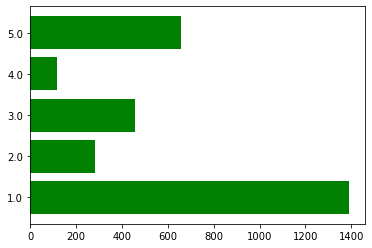




AGE
Age Of Respondent


count    2898.000000
mean       44.777088
std        16.867696
min        18.000000
25%        32.000000
50%        42.000000
75%        55.000000
max        89.000000
Name: age, dtype: float64




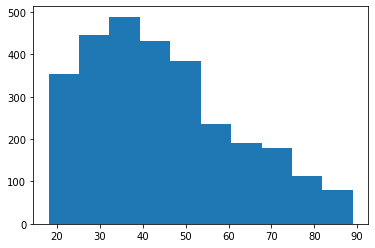

(array([353., 445., 489., 431., 384., 235., 190., 178., 114.,  79.]), array([18. , 25.1, 32.2, 39.3, 46.4, 53.5, 60.6, 67.7, 74.8, 81.9, 89. ]), <BarContainer object of 10 artists>)


In [7]:
#Get priliminary summary statistics and bar chart/histogram for all variables
for item in varlist:
    print("\n"*2)
    print(item.upper())
    print(labels[item].title())
    print("\n")
    summarize(gss, item)

<p><b>Summary Statistics of Interest.</b></p>
Next, we look at the summary of a few variables of interest, explaining how each variable is measured and why we are using it in this analysis. Presented are charts of participants' purchasing decisions. In each case, they indicate whether or not they used a specific influence as a main driver in their purchasing deicison. You can see the results of these for the four types of products in our analysis: car buying, home buying, lawyer hiring, and repair-person hiring.

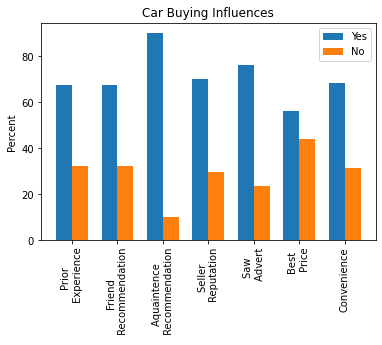

In [10]:
labels = ['Prior \n Experience', 'Friend \n Recommendation', 'Aquaintence \n Recommendation', 'Seller \n Reputation', 'Saw \n Advert', "Best \n Price",'Convenience']
yesses=[]
nos=[]
carvars = ["carbuya_r", "carbuyb_r", "carbuyc_r", "carbuyd_r", "carbuye_r", "carbuyf_r", "carbuyg_r"]
for item in carvars:
    yesses.append(len(car.loc[car[item] == 1]) / len(car[item]) *100)
for item in carvars:
    nos.append(len(car.loc[car[item] == 0]) / len(car[item])*100)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yesses, width, label='Yes')
rects2 = ax.bar(x + width/2, nos, width, label='No')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_title('Car Buying Influences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation = 90)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

#fig.tight_layout()

plt.show()


<ipython-input-11-fcf40bb65364>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


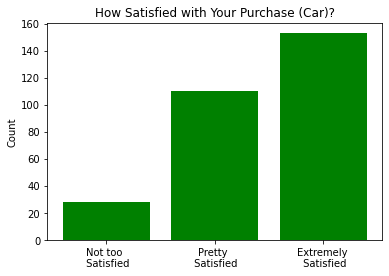

In [11]:
labels = ['Not too \n Satisfied', 'Pretty \n Satisfied', 'Extremely \n Satisfied']

homesum=[]
carsum=[]
fixsum=[]
lawsum=[]
heightlist=[]
for i in range(1,4):
    heightlist.append((len(car.loc[car["satcar"] == i])))

x=[0,1,2]
fig, ax = plt.subplots()
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, heightlist, color='green')
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_title('How Satisfied with Your Purchase (Car)?')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

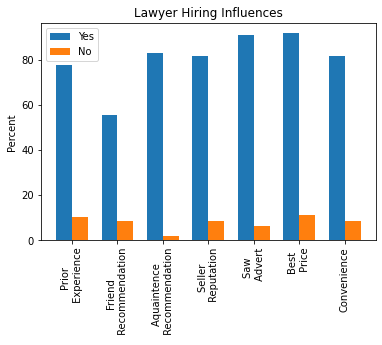

In [12]:
labels = ['Prior \n Experience', 'Friend \n Recommendation', 'Aquaintence \n Recommendation', 'Seller \n Reputation', 'Saw \n Advert', "Best \n Price",'Convenience']
yesses=[]
nos=[]
lawvars = ["lawyera_r", "lawyerb_r", "lawyerc_r", "lawyerd_r", "lawyere_r", "lawyerf_r", "lawyerg_r"]
for item in lawvars:
    yesses.append(len(law.loc[law[item] == 1]) / len(law[item]) *100)
for item in carvars:
    nos.append(len(law.loc[law[item] == 0]) / len(law[item])*100)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yesses, width, label='Yes')
rects2 = ax.bar(x + width/2, nos, width, label='No')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_title('Lawyer Hiring Influences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation = 90)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

#fig.tight_layout()

plt.show()


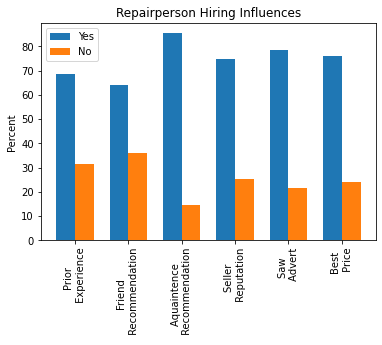

In [13]:
labels = ['Prior \n Experience', 'Friend \n Recommendation', 'Aquaintence \n Recommendation', 'Seller \n Reputation', 'Saw \n Advert', "Best \n Price"]
yesses=[]
nos=[]
fixvars = ["fixera_r", "fixerb_r", "fixerc_r", "fixerd_r", "fixere_r", "fixerf_r"]
for item in fixvars:
    yesses.append(len(fix.loc[fix[item] == 1]) / len(fix[item]) *100)
for item in fixvars:
    nos.append(len(fix.loc[fix[item] == 0]) / len(fix[item])*100)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yesses, width, label='Yes')
rects2 = ax.bar(x + width/2, nos, width, label='No')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_title('Repairperson Hiring Influences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation = 90)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

#fig.tight_layout()

plt.show()


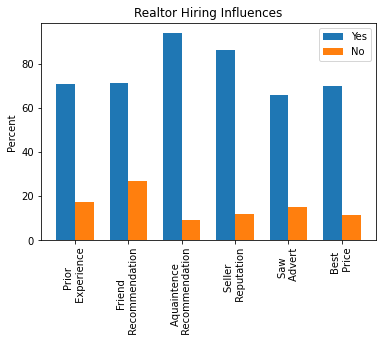

In [14]:
labels = ['Prior \n Experience', 'Friend \n Recommendation', 'Aquaintence \n Recommendation', 'Seller \n Reputation', 'Saw \n Advert', "Best \n Price"]
yesses=[]
nos=[]
homevars = ["realtora_r", "realtorb_r", "realtorc_r", "realtord_r", "realtore_r", "realtorf_r"]
for item in homevars:
    yesses.append(len(home.loc[home[item] == 1]) / len(home[item]) *100)
for item in fixvars:
    nos.append(len(home.loc[home[item] == 0]) / len(home[item])*100)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, yesses, width, label='Yes')
rects2 = ax.bar(x + width/2, nos, width, label='No')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_title('Realtor Hiring Influences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation = 90)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

#fig.tight_layout()

plt.show()

<h2>What really matters?</h2>
<p>Of particular note is this variable, which measures what factors respondants believed were most influential in their decision making</p>

<ipython-input-16-15d864b232a0>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


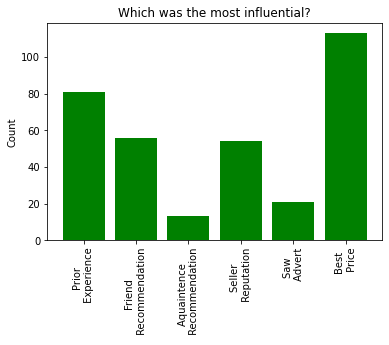

In [16]:
labels = ['Prior \n Experience', 'Friend \n Recommendation', 'Aquaintence \n Recommendation', 'Seller \n Reputation', 'Saw \n Advert', "Best \n Price"]

homesum=[]
carsum=[]
fixsum=[]
lawsum=[]
for i in range(1,7):
    homesum.append(len(home.loc[home["realtor1"] == i]))
    carsum.append(len(car.loc[car["carbuy1"] == i]))
    fixsum.append(len(fix.loc[fix["fixer1"] == i]))
    lawsum.append (len(law.loc[law["lawyer1"] == i]))

one=homesum[0]+carsum[0]+fixsum[0]+lawsum[0]
two=homesum[1]+carsum[1]+fixsum[1]+lawsum[1]
three=homesum[2]+carsum[2]+fixsum[2]+lawsum[2]
four=homesum[3]+carsum[3]+fixsum[3]+lawsum[3]
five=homesum[4]+carsum[4]+fixsum[4]+lawsum[4]
six=homesum[5]+carsum[5]+fixsum[5]+lawsum[5]

heightlist=[one, two, three, four, five, six]
x=[0,1,2,3,4,5]
fig, ax = plt.subplots()
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, heightlist, color='green')
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_title('Which was the most influential?')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.show()

<h1>Regression Analysis</h1>
<p>Now we will conduct our regression analysis of the data, examining the relationship between these various influences and peoples' satisfaction with their ultimate purchase. The results are similar across each of the four product types, so rather than present each one separately, I will use the car-buying dataset as an illustrative case.

                            OLS Regression Results                            
Dep. Variable:                 satcar   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     3.101
Date:                Mon, 29 Mar 2021   Prob (F-statistic):            0.00363
Time:                        06:05:31   Log-Likelihood:                -281.87
No. Observations:                 291   AIC:                             579.7
Df Residuals:                     283   BIC:                             609.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1157      0.369      8.436      0.0

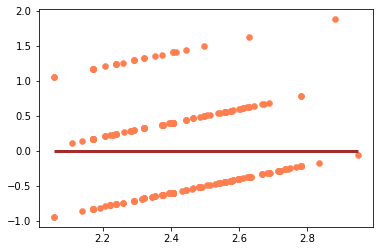

In [18]:
regress(car,"satcar","carbuya","carbuyb","carbuyc","carbuyd","carbuye","carbuyf","carbuyg")

In [ ]:
After a few rounds of removing variables that lack significant impact, and then removing other variables which become insignificant when others are removed from the model, we are left with only two significant variables (carbuya being left in despite barely making the cut here).

/home/ygael/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
                            OLS Regression Results                            
Dep. Variable:                 satcar   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     6.590
Date:                Mon, 29 Mar 2021   Prob (F-statistic):            0.00159
Time:                        05:53:29   Log-Likelihood:                -286.11
No. Observations:                 291   AIC:                             578.2
Df Residuals:                     288   BIC:                             589.2
Df 

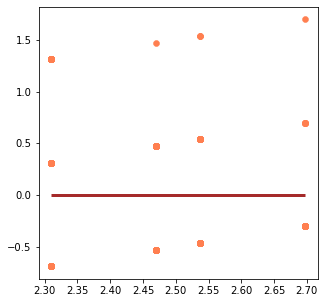

In [251]:
regress(car,"satcar","carbuya","carbuyd")

/home/ygael/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
                            OLS Regression Results                            
Dep. Variable:               satfixes   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.029
Date:                Mon, 29 Mar 2021   Prob (F-statistic):             0.0454
Time:                        05:54:26   Log-Likelihood:                -353.66
No. Observations:                 390   AIC:                             711.3
Df Residuals:                     388   BIC:                             719.2
Df 

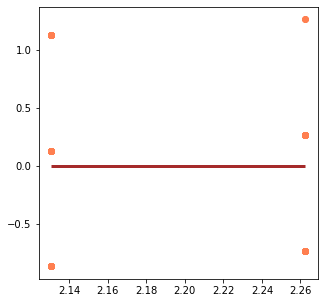

In [258]:
regress(fix,"satfixes","fixera")
